In [1]:
import sys,os
sys.path.append(sys.path[0]+'/../../utils/')

from simulators import *
from polytope import *
from utils import *
from fnc.FTO import *
from fnc.LMPC_CS import LMPC_CS
import matplotlib
import matplotlib.pyplot as plt
import copy
import pickle
import pdb
import numpy as np

# Part 1: LMPC for performance improvement
- Step 1: Run MPC with long horizon to compute first feasible solution
- Step 2: Run LMPC to improve the closed-loop performance

In [2]:
# Initial Condition
x0 = [-15.0, 0.0];

# Define system matrices and cost matrices
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])
Q = np.diag([1.0, 1.0])
R = np.array([1.0]).reshape(1,1)
u_max = 5
x_max = 15
# Initialize FTOCP object
N_mpc = 10
simulator = SIMULATOR("linear_system", A = A, B = B)
ftocp  = FTOCP(N_mpc, A, B, 0.001*Q, 0.001*Q, R, x_max, u_max)

# ====================================================================================
# Run simulation to compute feasible solution
# ====================================================================================
xcl_feasible = [x0]
ucl_feasible =[]
xt           = x0
time         = 0

print("Start closed-loop simulation")
while np.dot(xt, xt) > 10**(-15):
    xt = xcl_feasible[time] # Read measurements

    ftocp.solve(xt, verbose = False) # Solve FTOCP

    # Read input and apply it to the system
    ut = ftocp.uPred[:,0][0]
    ucl_feasible.append(ut)
    xcl_feasible.append(simulator.sim(xcl_feasible[time], ut))
    time += 1
print("Done closed-loop simulation")



Start closed-loop simulation
Done closed-loop simulation


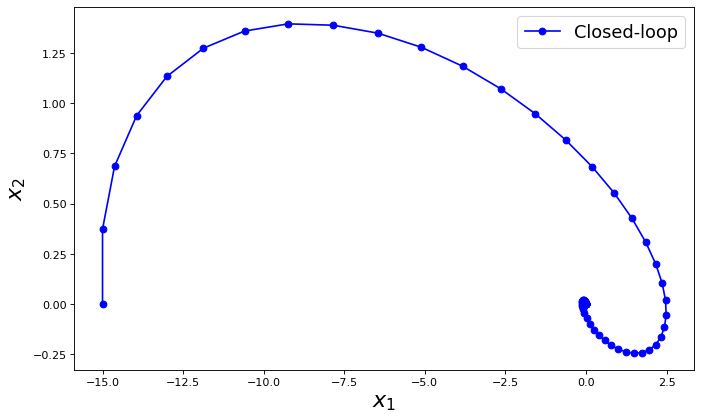

In [3]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(np.array(xcl_feasible)[:, 0], np.array(xcl_feasible)[:, 1], '-ob', label='Closed-loop')
plt.legend(fontsize=16)

plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

plt.show()

**Next we run the LMPC to iteratively improve the performance**

In [4]:
# ====================================================================================
# Run LMPC
# ====================================================================================

# Initialize LMPC object
N_LMPC = 3 # horizon length
Q1 = 0.01*Q
lmpc = LMPC_CS(N_LMPC, A, B, Q1, Q, R, x_max, u_max) # Initialize the LMPC (decide if you wanna use the CVX hull)
lmpc.addTrajectory(xcl_feasible, ucl_feasible) # Add feasible trajectory to the safe set

totalIterations = 20 # Number of iterations to perform

# run simulation
# iteration loop
print("Starting LMPC")
for it in range(0,totalIterations):
    # Set initial condition at each iteration
    xcl = [x0] 
    ucl =[]
    time = 0
    # time Loop (Perform the task until close to the origin)
    while np.dot(xcl[time], xcl[time]) > 10**(-15):

        # Read measurement
        xt = xcl[time] 
        
        # Solve FTOCP
        lmpc.solve(xt, verbose = False) 
        # Read optimal input
        ut = lmpc.uPred[:,0][0]

        # Apply optimal input to the system
        ucl.append(ut)
        xcl.append(simulator.sim(xcl[time], ut))
        time += 1

    # Add trajectory to update the safe set and value function
    lmpc.addTrajectory(xcl, ucl)
    print("Completed iteration: ", it, ". Iteration cost: ", lmpc.it_cost[-1])


Starting LMPC
Completed iteration:  0 . Iteration cost:  678.68692640332
Completed iteration:  1 . Iteration cost:  674.1917338466048
Completed iteration:  2 . Iteration cost:  673.8265727014068
Completed iteration:  3 . Iteration cost:  673.731904785738
Completed iteration:  4 . Iteration cost:  673.698427195963
Completed iteration:  5 . Iteration cost:  673.6857838674479
Completed iteration:  6 . Iteration cost:  673.6806648301874
Completed iteration:  7 . Iteration cost:  673.6784712746721
Completed iteration:  8 . Iteration cost:  673.6775003974388
Completed iteration:  9 . Iteration cost:  673.6770573190722
Completed iteration:  10 . Iteration cost:  673.6768506197886
Completed iteration:  11 . Iteration cost:  673.6767517832593
Completed iteration:  12 . Iteration cost:  673.6767033389041
Completed iteration:  13 . Iteration cost:  673.6766791350741
Completed iteration:  14 . Iteration cost:  673.6766668363214
Completed iteration:  15 . Iteration cost:  673.6766605109748
Complete

**Next we run the LMPC to iteratively improve the performance**

In [5]:
# Compute optimal solution
N = 1000 # Set a very long horizon to fake infinite time optimal control problem
ftocp_opt = FTOCP(N, A, B, Q1, Q, R, x_max, u_max)
ftocp_opt.solve(xcl[0])
xOpt = ftocp_opt.xPred
uOpt = ftocp_opt.uPred
costOpt = lmpc.computeCost(xOpt.T.tolist(), uOpt.T.tolist())
print("Optimal cost is: ", costOpt[0])

Optimal cost is:  673.676653449659


**Compare closed-loop trajectories and iteration cost**

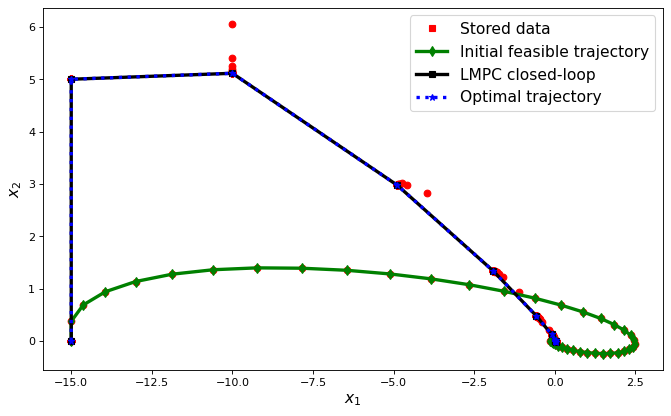

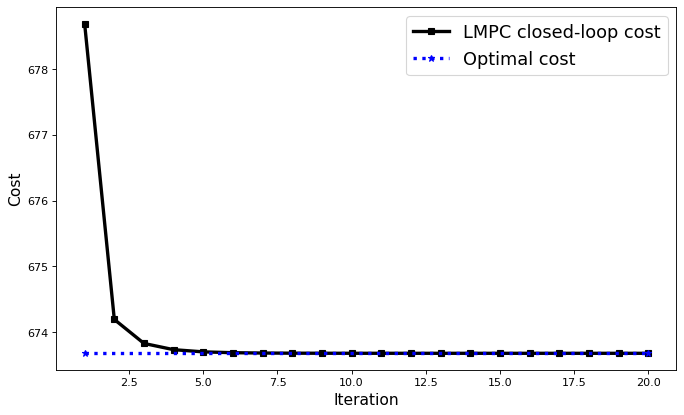

In [6]:
it = len(lmpc.it_cost)
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(lmpc.SS[0,:], lmpc.SS[1,:], 'or')
plt.plot(0, 0, 'sr', label='Stored data')
plt.plot(np.array(xcl_feasible).T[0,:], np.array(xcl_feasible).T[1,:], '-dg', linewidth=3, label='Initial feasible trajectory')
plt.plot(np.array(xcl).T[0,:], np.array(xcl).T[1,:], '-sk', linewidth=3, label='LMPC closed-loop')
plt.plot(xOpt[0,:], xOpt[1,:], ':*b', linewidth=3, label='Optimal trajectory')
plt.legend(fontsize=14)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(np.arange(1, len(lmpc.it_cost)), lmpc.it_cost[1:], '-sk', linewidth=3, label='LMPC closed-loop cost')
plt.plot([1, len(lmpc.it_cost)-1], [costOpt[0], costOpt[0]], ':*b', linewidth=3, label='Optimal cost')
plt.legend(fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.savefig('LinearLMPC_cost.pdf')
plt.show()


# Part 2: Enlarge the region of attraction

In [7]:
# First compute invaraint set for LQR gain
u_max = 1.5 # Update input constraints
P, K, Acl = dlqr(A, B, Q, R)
Fx = np.vstack((np.eye(A.shape[1]), -np.eye(A.shape[1])))
bx = np.repeat(x_max, Fx.shape[0])
Fu = np.vstack((np.eye(B.shape[1]), -np.eye(B.shape[1])))
bu = np.repeat(u_max, Fu.shape[0])

Ftot = np.vstack((Fx, np.dot(Fu, -K)))
btot = np.hstack((bx, bu ))

# Compute the invariant set assocaited with the LQR gain
Oinf = polytope(Ftot, btot)
Oinf.computeO_inf(Acl)

# Compute region of attraction for an MPC with horizon N = 3
N = 3
RoA_MPC = polytope(Ftot, btot)
RoA_MPC.NStepPreAB(A, B, Fx, bx, Fu, bu, N)


Oinfinity computation terminated after  1  iterations


Start LMPC with initial condition x =  [ 1.5 -1.5]
Start LMPC with initial condition x =  [-1.5  1.5]


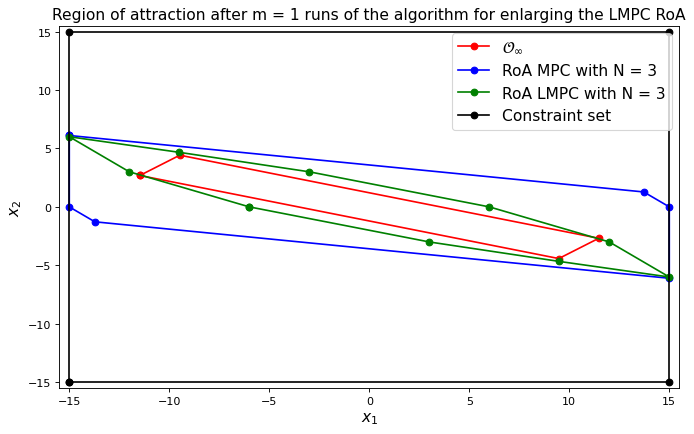

Start LMPC with initial condition x =  [-15.   6.]
Start LMPC with initial condition x =  [-9.494988  4.664996]
Start LMPC with initial condition x =  [12. -3.]
Start LMPC with initial condition x =  [ 3. -3.]
Start LMPC with initial condition x =  [ 6.00000000e+00 -7.99360578e-15]
Start LMPC with initial condition x =  [-6.0000000e+00 -8.8817842e-15]
Start LMPC with initial condition x =  [-3.  3.]
Start LMPC with initial condition x =  [-12.   3.]
Start LMPC with initial condition x =  [ 9.495003 -4.665001]
Start LMPC with initial condition x =  [15. -6.]


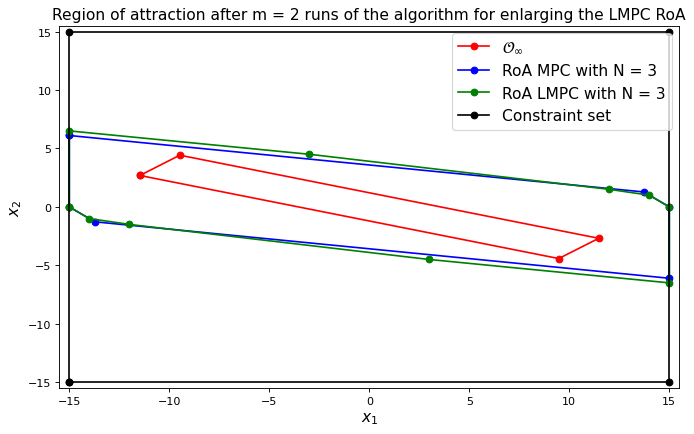

Start LMPC with initial condition x =  [-3.   4.5]
Start LMPC with initial condition x =  [-15.    6.5]
Start LMPC with initial condition x =  [12.   1.5]
Start LMPC with initial condition x =  [14.  1.]
Start LMPC with initial condition x =  [15.  0.]
Start LMPC with initial condition x =  [-1.50000000e+01 -2.84217094e-15]
Start LMPC with initial condition x =  [-14.  -1.]
Start LMPC with initial condition x =  [-12.   -1.5]
Start LMPC with initial condition x =  [15.  -6.5]
Start LMPC with initial condition x =  [ 3.  -4.5]


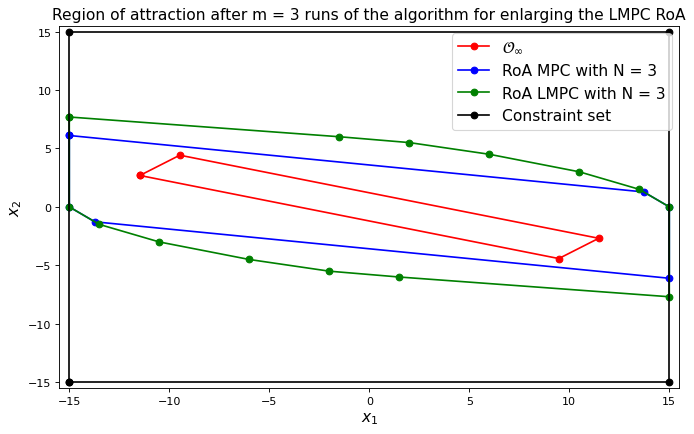

Start LMPC with initial condition x =  [-1.5  6. ]
Start LMPC with initial condition x =  [-15.       7.6875]
Start LMPC with initial condition x =  [2.  5.5]
Start LMPC with initial condition x =  [6.  4.5]
Start LMPC with initial condition x =  [10.5  3. ]
Start LMPC with initial condition x =  [13.5  1.5]
Start LMPC with initial condition x =  [15.  0.]
Start LMPC with initial condition x =  [-1.50000000e+01 -4.73695157e-15]
Start LMPC with initial condition x =  [-13.5  -1.5]
Start LMPC with initial condition x =  [-10.5  -3. ]
Start LMPC with initial condition x =  [-6.  -4.5]
Start LMPC with initial condition x =  [-2.  -5.5]
Start LMPC with initial condition x =  [15.     -7.6875]
Start LMPC with initial condition x =  [ 1.5 -6. ]


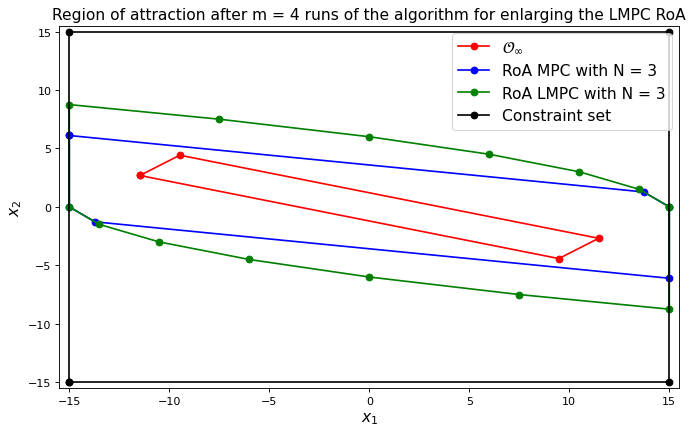

Start LMPC with initial condition x =  [-7.5  7.5]
Start LMPC with initial condition x =  [-15.     8.75]
Start LMPC with initial condition x =  [-8.79719578e-15  6.00000000e+00]
Start LMPC with initial condition x =  [6.  4.5]
Start LMPC with initial condition x =  [10.5  3. ]
Start LMPC with initial condition x =  [13.5  1.5]
Start LMPC with initial condition x =  [ 1.5000000e+01 -8.8817842e-15]
Start LMPC with initial condition x =  [-15.   0.]
Start LMPC with initial condition x =  [-13.5  -1.5]
Start LMPC with initial condition x =  [-10.5  -3. ]
Start LMPC with initial condition x =  [-6.  -4.5]
Start LMPC with initial condition x =  [-4.26325641e-14 -6.00000000e+00]
Start LMPC with initial condition x =  [15.   -8.75]
Start LMPC with initial condition x =  [ 7.5 -7.5]


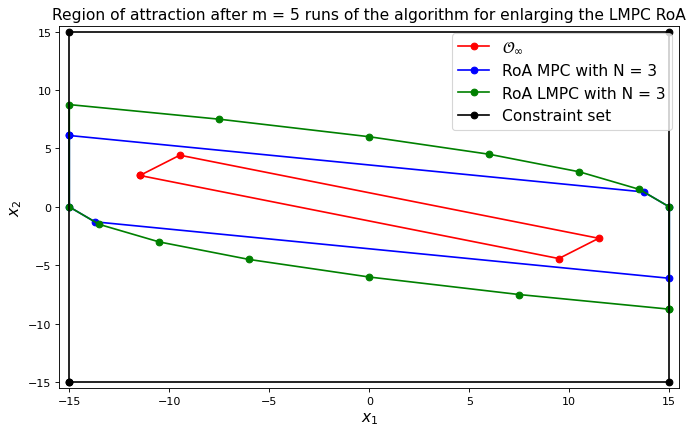

In [8]:
lmpc = LMPC_CS(N_LMPC, A, B, Q1, Q, R, x_max, u_max) # Initialize the LMPC (decide if you wanna use the CVX hull)
# run simulation
# iteration loop
M = 5
for m in range(M):
    if m == 0: 
    # if initial step of the algorithm (m=0) --> Start from the states that can be steered to the origin in 1 step
    # This steps assumes that we are controlling a double integrator
        vertices = np.array([[u_max, -u_max],
                            [-u_max,  u_max]])
    else:
    # if m>1 --> use vertices from the LMPC Region of Attraction (RoA)
        vertices = RoA_LMPC.vertices
    for v in vertices:
        # Set initial condition at each iteration
        xcl = [v] 
        ucl =[]
        time = 0
        print("Start LMPC with initial condition x = ", xcl[0])
        # time Loop (Perform the task until close to the origin)
        while np.dot(xcl[time], xcl[time]) > 10**(-15):

            # Read measurement
            xt = xcl[time] 

            # Solve FTOCP
            lmpc.solve(xt, verbose = False) 
            # Read optimal input
            ut = lmpc.uPred[:,0][0]

            # Apply optimal input to the system
            ucl.append(ut)
            xcl.append(simulator.sim(xcl[time], ut))
            time += 1

        # Add trajectory to update the safe set and value function
        lmpc.addTrajectory(xcl, ucl)

    # Update LMPC region of attraction
    RoA_LMPC = polytope(vertices=lmpc.SS.T)
    RoA_LMPC.NStepPreAB(A, B, Fx, bx, Fu, bu, N)
    RoA_LMPC.computeVRep()
    
    # Plot intermediate results
    X = polytope(Fx, bx)
    plt.figure(figsize=(10, 6), dpi=80)
    Oinf.plot2DPolytope('r', label='$\mathcal{O}_\infty$')
    RoA_MPC.plot2DPolytope('b', label='RoA MPC with N = 3')
    RoA_LMPC.plot2DPolytope('g', label='RoA LMPC with N = 3')
    X.plot2DPolytope('k', label='Constraint set')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-x_max-0.5,x_max+0.5)
    plt.ylim(-x_max-0.5,x_max+0.5)
    plt.legend(fontsize=14, loc=1)
    plt.title('Region of attraction after m = '+str(m+1)+' runs of the algorithm for enlarging the LMPC RoA', fontsize=14)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14)
    plt.show()
    

## Plot final comparison between MPC and LMPC regions of attractions

Cinfinity computation terminated after  6  iterations


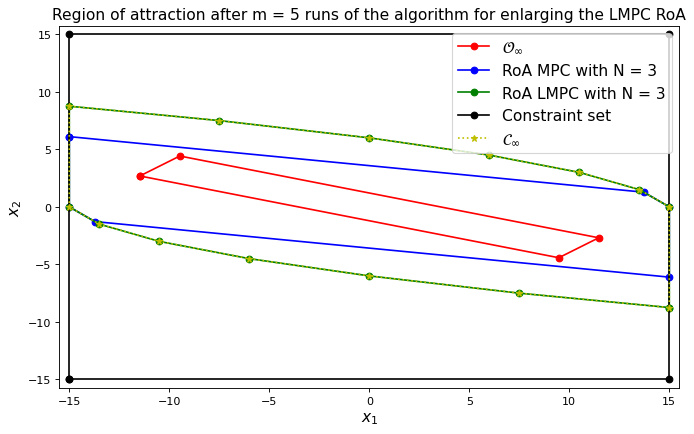

In [9]:
# Plot final results
Cinfty = polytope(Fx, bx)
Cinfty.computeC_inf(A, B, Fu, bu)
RoA_LMPC = polytope(vertices=lmpc.SS.T)
RoA_LMPC.NStepPreAB(A, B, Fx, bx, Fu, bu, N)
RoA_LMPC.computeVRep()
plt.figure(figsize=(10, 6), dpi=80)
Oinf.plot2DPolytope('r', label='$\mathcal{O}_\infty$')
RoA_MPC.plot2DPolytope('b', label='RoA MPC with N = 3')
RoA_LMPC.plot2DPolytope('g', label='RoA LMPC with N = 3')
X.plot2DPolytope('k', label='Constraint set')
Cinfty.plot2DPolytope('y', linestyle=':*', label='$\mathcal{C}_\infty$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.xlim(-x_max-0.5,x_max+0.5)
plt.ylim(-x_max-0.75,x_max+0.75)
plt.legend(fontsize=14, loc=1)
plt.title('Region of attraction after m = '+str(m+1)+' runs of the algorithm for enlarging the LMPC RoA', fontsize=14)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.savefig('LinearLMPC_RoA_comparison.pdf')
plt.show()